# Figure 10

**Figure 10.** Mean uncertainties in CRH diagnosed as the absolute difference of domain and time mean CRH between different radiative transfer calculations. Uncertainties are decomposed into shortwave, longwave, and net. Uncertainties are computed as mass-weighted averages over 2 km altitude intervals. For the uncertainty due to the ice-optical parameterization, the difference between the ice schemes of Fu and Baum with the general habit mixture is used. The contribution of each factor is given by the horizontal length of its colored bar. Note the different x-axes in the panels.

---
@ Behrooz Keshtgar, KIT 2024

## 1- load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import colorlegend
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

For reference, print package versions to screen:

In [2]:
print('xarrary:   ', xr.__version__)
print('numpy:     ', np.__version__)
import matplotlib; print('matplotlib:', matplotlib.__version__); del matplotlib

xarrary:    0.16.0
numpy:      1.23.5
matplotlib: 3.3.0


**Since datasets are large, I use DASK to speed up my analysis**

In [3]:
import dask
from dask.distributed import Client, progress, wait
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()
client

<Client: 'tcp://127.0.0.1:44355' processes=16 threads=256, memory=252.72 GB>

## 2- Loading datasets

In [4]:
# Dictionary for loading datasets for the 4 LEM domains
domdict = {
         'shallow_cumulus'          : {'res':'300m'}, 
         'WCB_ascent'               : {'res':'300m'}, 
         'WCB_cyclonic_outflow'     : {'res':'300m'}, 
         'WCB_anticyclonic_outflow' : {'res':'300m'}
          }

In [5]:
# Loading icon-pp datasets
def load_data():
    list_icon = []
    for dom in list(domdict.keys()):
        path = '/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/'
        print('Working on loading data for', dom)
        ds = xr.open_dataset(path+dom+'/icon_pp_data.nc').chunk(chunks={'time': 1, 'height': 10})
        list_icon.append(ds)
    return list_icon
#-------------------------------------------------------------------------------------------------
list_icon=load_data()

Working on loading data for shallow_cumulus
Working on loading data for WCB_ascent
Working on loading data for WCB_cyclonic_outflow
Working on loading data for WCB_anticyclonic_outflow


### Domain and time average of density

In [ ]:
# takin domain average
# icon datasets
for dom in range(len(list_icon)):
    for var in ['rho']:
        list_icon[dom][var+'_mean'] = list_icon[dom][var].isel(lon=slice(10,list_icon[dom].lon.size-10),lat=slice(5,list_icon[dom].lat.size-5)).mean(dim=['lat','lon','time']).compute()

### CRH profiles from previous analysis

In [8]:
fig6 = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure6.nc')
fig8 = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure8.nc')
fig9 = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure9.nc')

### For data publication

In [63]:
# creating a dataset and save for data publication
ds_out = xr.Dataset(
    data_vars={
        "rho_mean_icon_dom01"        : (list_icon[0]['rho_mean'].dims, list_icon[0]['rho_mean'].data),
        "rho_mean_icon_dom02"        : (list_icon[1]['rho_mean'].dims, list_icon[1]['rho_mean'].data),
        "rho_mean_icon_dom03"        : (list_icon[2]['rho_mean'].dims, list_icon[2]['rho_mean'].data),
        "rho_mean_icon_dom04"        : (list_icon[3]['rho_mean'].dims, list_icon[3]['rho_mean'].data),
  
    },
    coords=list_icon[0]['rho_mean'].coords)

ds_out = xr.merge([fig6,fig8,fig9,ds_out])

ds_out.attrs['description'] = 'Vertical profiles of CRH and density from different offline radiation calculations for each LEM domain'
ds_out.to_netcdf('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure10.nc')

In [3]:
ds_out = xr.open_dataset('/work/bb1135/b381185/icon_output/data_for_crh_unc_paper/postprocessed_data_for_publication/for_publication/figure10.nc')

## 3- Calculating weighted vertical mean of absolute mean differences

In [4]:
def absolute_mean_difference(ds, dom, rho):
    """
    Calculate AMD and weighted vertical mean in vertical intervals of 2 km.
    Input is a dataset containing time and spatial mean from different radiation calculations.
    """
    # thickness
    dp = np.zeros((140))
    dp[1:-1] = (rho[2:] - rho[:-2]) 
    dp[0] = (rho[1] - rho[0]) 
    dp[-1] = (rho[-1] - rho[-2])
    dp = dp[::-1]
    
    amd_list = []
    # Define functions for repeated calculations
    def calculate_amd_vm(data, dp):
        return np.array([(np.sum(data[i:j] * dp[i:j]) / np.sum(dp[i:j])) for i, j in zip([0, 28, 45, 59, 71, 82], [28, 45, 59, 71, 82, 92])])

    def calculate_and_append_amd_vm(prefix1, prefix2, ds):
        if prefix1 == 'smean_mystic':
            lw_amd = np.abs((ds[f'lwcrh_{prefix1}_{dom}'].mean('time') - ds[f'lwcrh_{prefix2}_{dom}'].mean('time')).values)
            sw_amd = np.abs((ds[f'swcrh_{prefix1}_{dom}'].mean('time') - ds[f'swcrh_{prefix2}_{dom}'].mean('time')).values)
            
            net1 = ds[f'lwcrh_{prefix1}_{dom}'].mean('time') + ds[f'swcrh_{prefix1}_{dom}'].mean('time')
            net2 = ds[f'lwcrh_{prefix2}_{dom}'].mean('time') + ds[f'swcrh_{prefix2}_{dom}'].mean('time')
            nt_amd = np.abs((net1 - net2).values)
            
        else:
            lw_amd = np.abs((ds[f'lwcrh_{prefix1}_{dom}'] - ds[f'lwcrh_{prefix2}_{dom}']).values)
            sw_amd = np.abs((ds[f'swcrh_{prefix1}_{dom}'] - ds[f'swcrh_{prefix2}_{dom}']).values)
            
            net1 = ds[f'lwcrh_{prefix1}_{dom}'] + ds[f'swcrh_{prefix1}_{dom}']
            net2 = ds[f'lwcrh_{prefix2}_{dom}'] + ds[f'swcrh_{prefix2}_{dom}']
            nt_amd = np.abs((net1 - net2).values)
        
        lw_amd_vm = calculate_amd_vm(lw_amd, dp)
        sw_amd_vm = calculate_amd_vm(sw_amd, dp)
        nt_amd_vm = calculate_amd_vm(nt_amd, dp)
    
        amd_list.append(lw_amd_vm)
        amd_list.append(sw_amd_vm)
        amd_list.append(nt_amd_vm)

    # 3D cloud radiative effects
    calculate_and_append_amd_vm('smean_mystic', 'smean_mystic_ica', ds)

    # Impact of cloud horizontal heterogeneity
    calculate_and_append_amd_vm('mean_nwp', 'mean_lem', ds)

    # Impact of cloud horizontal heterogeneity and cloud vertical overlap
    calculate_and_append_amd_vm('mean_nwpfr', 'mean_lem', ds)

    # Impact of ice-optical param
    if dom == 'dom01':
        amd_list.extend([np.zeros(6), np.zeros(6), np.zeros(6)])
    else:
        calculate_and_append_amd_vm('mean_fu', 'mean_Baum_ghm', ds)

    return amd_list

In [5]:
amd_dom01 = absolute_mean_difference(ds_out,'dom01',ds_out['rho_mean_icon_dom01'].values)
amd_dom02 = absolute_mean_difference(ds_out,'dom02',ds_out['rho_mean_icon_dom02'].values)
amd_dom03 = absolute_mean_difference(ds_out,'dom03',ds_out['rho_mean_icon_dom03'].values)
amd_dom04 = absolute_mean_difference(ds_out,'dom04',ds_out['rho_mean_icon_dom04'].values)

## 4- Plot

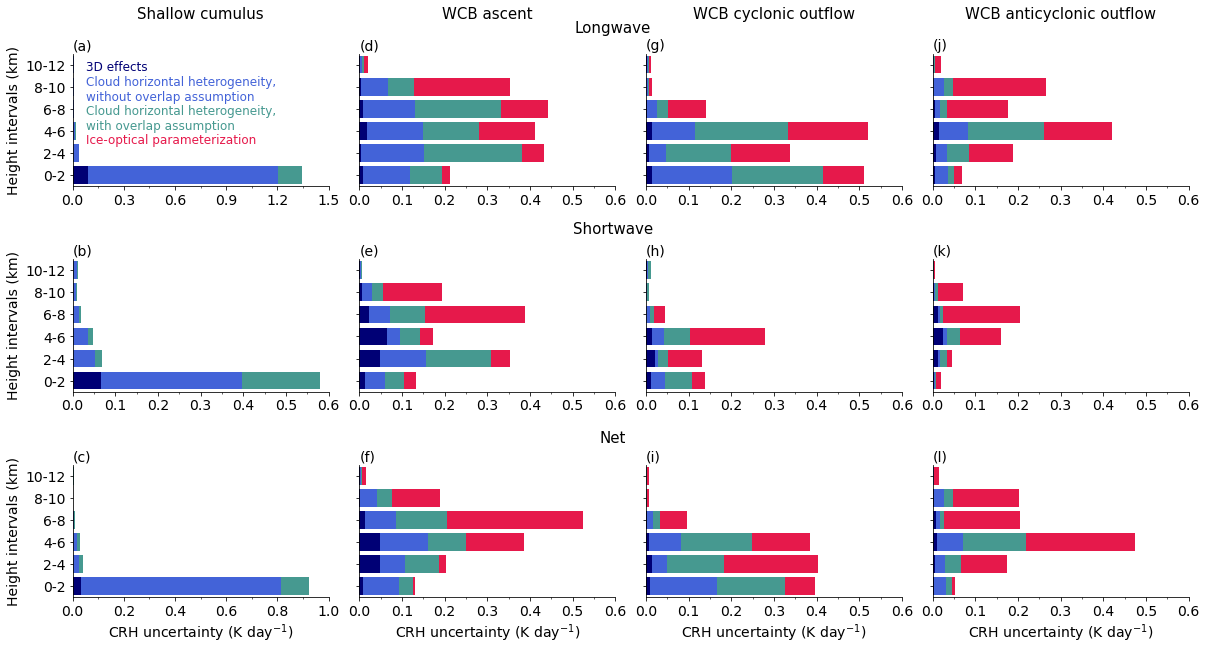

In [8]:
# height intervals
h1 = np.arange(0,6,1)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10)) 
i = 0

for ax in axes.flat:
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    ############################################################
    ####### Longwave ###########################################
    ############################################################
    if i == 0:

        ax.barh(h1, amd_dom01[0], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom01[3], color='#4363d8', left=amd_dom01[0], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom01[6], color='#469990', left=amd_dom01[0]+amd_dom01[3], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom01[9], color='#e6194B', left=amd_dom01[0]+amd_dom01[3]+amd_dom01[6], label='Ice-optical parameterization')
        #lg=colorlegend.color_legend(ax,loc=1,fsize=11)
        #ax.legend(frameon=False)
        ax.set_title('Shallow cumulus', fontsize=15,pad=35)
        #ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_ylabel('Height intervals (km)', fontsize=14)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlim([0.,1.5])
        ax.spines['bottom'].set_bounds(0,1.5)
        ax.set_xticks(np.linspace(0,1.5,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(a)', transform=ax.transAxes, 
            size=14)
        
        ax.text(0.08, 5.2, '3D effects', color = '#000075', size=12, va="top")
        ax.text(0.08, 4.5, 'Cloud horizontal heterogeneity,\nwithout overlap assumption', color='#4363d8', size=12, va="top")
        ax.text(0.08, 3.2, 'Cloud horizontal heterogeneity,\nwith overlap assumption', color='#469990', size=12, va="top")
        ax.text(0.08, 1.9, 'Ice-optical parameterization', color='#e6194B', size=12, va="top")
        
    if i == 1:
        
        ax.barh(h1, amd_dom02[0], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom02[3], color='#4363d8', left=amd_dom02[0], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom02[6], color='#469990', left=amd_dom02[0]+amd_dom02[3], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom02[9], color='#e6194B', left=amd_dom02[0]+amd_dom02[3]+amd_dom02[6], label='Ice-optical parameterization')
        ax.set_title('WCB ascent', fontsize=15,pad=35)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(d)', transform=ax.transAxes, 
            size=14)
        
    if i == 2:
        
        ax.barh(h1, amd_dom03[0], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom03[3], color='#4363d8', left=amd_dom03[0], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom03[6], color='#469990', left=amd_dom03[0]+amd_dom03[3], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom03[9], color='#e6194B', left=amd_dom03[0]+amd_dom03[3]+amd_dom03[6], label='Ice-optical parameterization')
        ax.set_title('WCB cyclonic outflow', fontsize=15,pad=35)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(g)', transform=ax.transAxes, 
            size=14)
        
    if i == 3:
        
        ax.barh(h1, amd_dom04[0], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom04[3], color='#4363d8', left=amd_dom04[0], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom04[6], color='#469990', left=amd_dom04[0]+amd_dom04[3], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom04[9], color='#e6194B', left=amd_dom04[0]+amd_dom04[3]+amd_dom04[6], label='Ice-optical parameterization')
        ax.set_title('WCB anticyclonic outflow', fontsize=15,pad=35)

        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(j)', transform=ax.transAxes, 
            size=14)   
    
    ################################################################## 
    ## Shortwave
    ##################################################################
    
    if i == 4:

        ax.barh(h1, amd_dom01[1], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom01[4], color='#4363d8', left=amd_dom01[1], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom01[7], color='#469990', left=amd_dom01[1]+amd_dom01[4], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom01[10], color='#e6194B', left=amd_dom01[1]+amd_dom01[4]+amd_dom01[7], label='Ice-optical parameterization')
        
        ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_xlim([0.0,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks(np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.text(0.0, 1.03, '(b)', transform=ax.transAxes, 
            size=14)
        
    if i == 5:

        ax.barh(h1, amd_dom02[1], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom02[4], color='#4363d8', left=amd_dom02[1], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom02[7], color='#469990', left=amd_dom02[1]+amd_dom02[4], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom02[10], color='#e6194B', left=amd_dom02[1]+amd_dom02[4]+amd_dom02[7], label='Ice-optical parameterization')
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.text(0.0, 1.03, '(e)', transform=ax.transAxes, 
            size=14)
        
        
    if i == 6:

        ax.barh(h1, amd_dom03[1], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom03[4], color='#4363d8', left=amd_dom03[1], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom03[7], color='#469990', left=amd_dom03[1]+amd_dom03[4], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom03[10], color='#e6194B', left=amd_dom03[1]+amd_dom03[4]+amd_dom03[7], label='Ice-optical parameterization')
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.text(0.0, 1.03, '(h)', transform=ax.transAxes, 
            size=14)
        
    if i == 7:

        ax.barh(h1, amd_dom04[1], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom04[4], color='#4363d8', left=amd_dom04[1], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom04[7], color='#469990', left=amd_dom04[1]+amd_dom04[4], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom04[10], color='#e6194B', left=amd_dom04[1]+amd_dom04[4]+amd_dom04[7], label='Ice-optical parameterization')
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.text(0.0, 1.03, '(k)', transform=ax.transAxes, 
            size=14)
        
    ############################################################
    ####### Net ################################################
    ############################################################
    if i == 8:
        
        ax.barh(h1, amd_dom01[2], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom01[5], color='#4363d8', left=amd_dom01[2], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom01[8], color='#469990', left=amd_dom01[2]+amd_dom01[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom01[11], color='#e6194B', left=amd_dom01[2]+amd_dom01[5]+amd_dom01[8], label='Ice-optical parameterization')
    
        ax.set_ylabel('Height intervals (km)', fontsize=14)
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_xlim([0.0,1])
        ax.spines['bottom'].set_bounds(0,1)
        ax.set_xticks(np.linspace(0,1,6))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(c)', transform=ax.transAxes, 
            size=14)
        
    if i == 9:
        
        ax.barh(h1, amd_dom02[2], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom02[5], color='#4363d8', left=amd_dom02[2], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom02[8], color='#469990', left=amd_dom02[2]+amd_dom02[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom02[11], color='#e6194B', left=amd_dom02[2]+amd_dom02[5]+amd_dom02[8], label='Ice-optical parameterization')
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(f)', transform=ax.transAxes, 
            size=14)
        
    if i == 10:
        
        ax.barh(h1, amd_dom03[2], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom03[5], color='#4363d8', left=amd_dom03[2], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom03[8], color='#469990', left=amd_dom03[2]+amd_dom03[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom03[11], color='#e6194B', left=amd_dom03[2]+amd_dom03[5]+amd_dom03[8], label='Ice-optical parameterization')
    
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(i)', transform=ax.transAxes, 
            size=14)
        
    if i == 11:
        
        ax.barh(h1, amd_dom04[2], color='#000075', label='3D effetcs')
        ax.barh(h1, amd_dom04[5], color='#4363d8', left=amd_dom04[2], label='Horizontal heterogeneity')
        ax.barh(h1, amd_dom04[8], color='#469990', left=amd_dom04[2]+amd_dom04[5], label='Horizontal heterogeneity and vertical overlap')
        ax.barh(h1, amd_dom04[11], color='#e6194B', left=amd_dom04[2]+amd_dom04[5]+amd_dom04[8], label='Ice-optical parameterization')
        
        ax.set_ylim([-0.5,5.5])
        ax.spines['left'].set_bounds(-0.5,5.5)
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels(['0-2','2-4','4-6','6-8','8-10','10-12'])
        ax.set_yticklabels([])
        
        ax.set_xlabel('CRH uncertainty (K day$^{-1}$)', fontsize=14)
        ax.set_xlim([0.,0.6])
        ax.spines['bottom'].set_bounds(0,0.6)
        ax.set_xticks( np.linspace(0,0.6,7))
        minor_locator = AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        
        ax.text(0.0, 1.03, '(l)', transform=ax.transAxes, 
            size=14)    
     
    i = i + 1     

fig.subplots_adjust(wspace=0.12,hspace=0.55)

plt.text(.5, 0.91, 'Longwave', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.63, 'Shortwave', transform=fig.transFigure, horizontalalignment='center',fontsize=15)
plt.text(.5, 0.34, 'Net', transform=fig.transFigure, horizontalalignment='center',fontsize=15)

plt.savefig('figure10.pdf', bbox_inches = 'tight')
plt.savefig('figure10.png', bbox_inches = 'tight',dpi=300)

In [14]:
client.close()